# Importing Libaries

In [0]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from data_cleaning import data_cleaner

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from data_preprocessing import data_preprocessor

from modelling import classification_metrics, custom_confusion_matrix, model_report, mixed_NB, mixed_NB_predict
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier

# Data Cleaning

In [0]:
data_cleaner('data/cardio_data.csv', 'data/cardio_data_clean.csv')

In [2]:
cardio_data = pd.read_csv('cardio_data_clean.csv')
cardio_data.head()

,age,gender,blood_pressure_max,blood_pressure_min,cholesterol_level,glucose_level,smoking_status,alcohol_status,activity_level,disease,bmi
0,39,1,110,70,1,1,0,0,1,1,31
1,64,1,120,70,1,1,0,0,1,1,26
2,55,0,140,90,2,2,0,0,1,1,31
3,54,0,130,80,1,3,0,0,1,1,29
4,60,1,120,80,2,2,0,1,1,1,20


# EDA

In [0]:
# EDA.ipynb notebook

# Data Preprocessing

In [0]:
X = cardio_data.drop(columns = ['disease'])
y = cardio_data['disease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

In [0]:
X_train_scaled = data_preprocessor(X_train)
X_test_scaled = data_preprocessor(X_test)

# Modelling

## Logistic Regression

### Training Model

In [0]:
lr = LogisticRegression()
lr_model = lr.fit(X_train_scaled, y_train)

y_test_hat = lr_model.predict(X_test_scaled)
y_test_proba = lr_model.predict_proba(X_test_scaled)[:,1]

### Model Report

Logistic Regression Model Report


- performance metrics (default threshold):

accuracy = 0.731, auc_score = 0.731

precision = 0.758, recall = 0.679, f1-score = 0.716

- ROC curve:



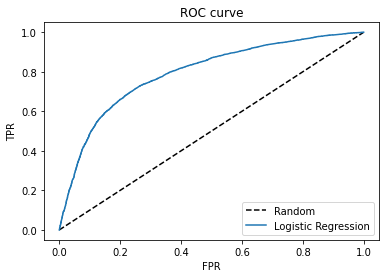


- optimal probability threshold:

0.46

- precision recall tradeoff:



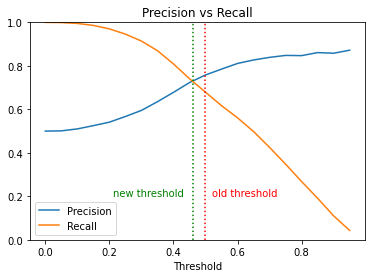


- performance metrics (new threshold):

accuracy = 0.732, auc_score = 0.732

precision = 0.734, recall = 0.728, f1-score = 0.731

- confusion matrix:



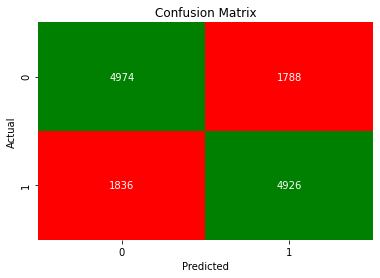

In [0]:
model_report(y_test, y_test_hat, y_test_proba, "Logistic Regression")

### Plotting Coefficients

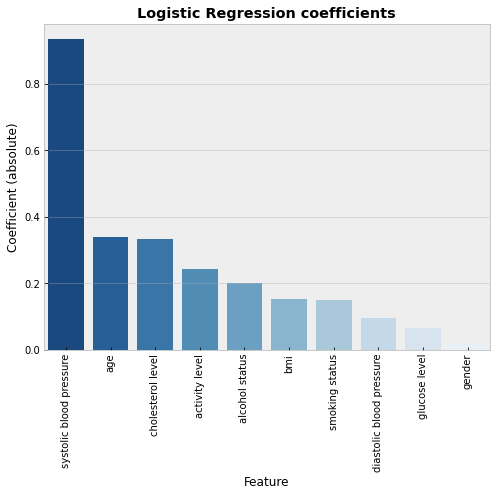

In [0]:
lr_coeffs = pd.DataFrame(list(zip(X_train_scaled.columns, np.absolute(lr_model.coef_[0]))), columns = ['feature', 'coefficient magnitude'])
lr_coeffs_sorted = lr_coeffs.sort_values(by = 'coefficient magnitude', ascending = False)

plt.style.use('bmh')

fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)
sns.barplot(data = lr_coeffs_sorted, x = 'feature', y = 'coefficient magnitude', ax = ax, palette = 'Blues_r')
ax.set_title('Logistic Regression coefficients', fontweight = 'bold')
ax.set_xlabel('Feature')
ax.set_ylabel('Coefficient (absolute)')
ax.set_xticklabels(['systolic blood pressure', 'age', 'cholesterol level', 'activity level', 'alcohol status', 'bmi', 'smoking status', 'diastolic blood pressure', 'glucose level', 'gender'])
plt.xticks(rotation = 90);

## k-Nearest Neighbours

### Baseline Model

#### Training Model

In [0]:
knn = KNeighborsClassifier()
base_knn_model = knn.fit(X_train_scaled, y_train)

y_test_hat = base_knn_model.predict(X_test_scaled)
y_test_proba = base_knn_model.predict_proba(X_test_scaled)

#### Validating Model

In [0]:
classification_metrics(y_test, y_test_hat)

accuracy = 0.694, auc_score = 0.694

precision = 0.696, recall = 0.688, f1-score = 0.692


### Hyperparameter Tuning

#### Inspecting range for k

In [0]:
ks = range(5,105,5)
scores = []
for k in ks:
    knn = KNeighborsClassifier(n_neighbors = k)
    score = np.mean(cross_val_score(knn, X_train_scaled, y_train, scoring = 'roc_auc', cv = 5))
    scores.append(score)

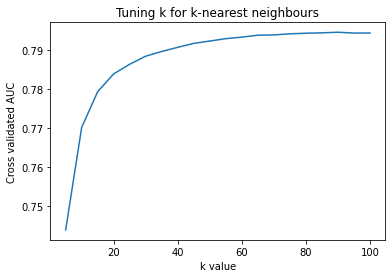

In [0]:
plt.plot(ks, scores)
plt.title('Tuning k for k-nearest neighbours')
plt.xlabel('k value')
plt.ylabel('Cross validated AUC');

#### Tuning k, distance and weight metric

In [0]:
param_grid = {'n_neighbors': range(40,120,20), 'weights': ['uniform', 'distance'], 'metric': ['manhattan', 'euclidean']}
knn_gs = GridSearchCV(knn, param_grid, scoring = 'roc_auc', cv = 5, n_jobs = -1)
%time knn_gs.fit(X_train_scaled, y_train)
knn_gs.best_params_

CPU times: user 2.17 s, sys: 120 ms, total: 2.29 s
Wall time: 3min 55s


{'metric': 'manhattan', 'n_neighbors': 100, 'weights': 'uniform'}

### Tuned Model

#### Training Model

In [0]:
tuned_knn = KNeighborsClassifier(n_neighbors = 100, metric = 'manhattan')
tuned_knn_model = tuned_knn.fit(X_train_scaled, y_train)

y_test_hat = tuned_knn_model.predict(X_test_scaled)
y_test_proba = tuned_knn_model.predict_proba(X_test_scaled)[:,1]

#### Model Report

k-Nearest Neighbours Model Report


- performance metrics (default threshold):

accuracy = 0.734, auc_score = 0.734

precision = 0.759, recall = 0.684, f1-score = 0.72

- ROC curve:



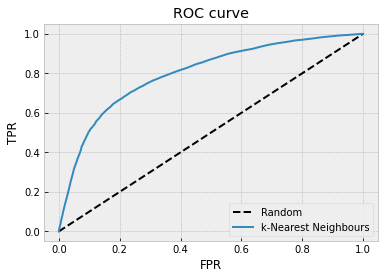


- optimal probability threshold:

0.49

- precision recall tradeoff:



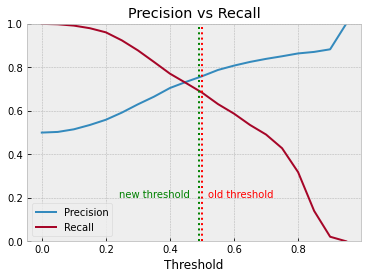


- performance metrics (new threshold):

accuracy = 0.733, auc_score = 0.733

precision = 0.754, recall = 0.693, f1-score = 0.722

- confusion matrix:



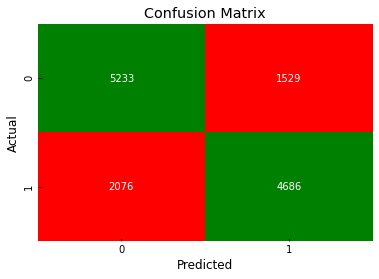

In [0]:
model_report(y_test, y_test_hat, y_test_proba, "k-Nearest Neighbours")

## Naive Bayes Classifier

### Categorical NB

#### Preprocessing Data

In [0]:
X_train_binned = data_preprocessor(X_train, bins = True)
X_test_binned = data_preprocessor(X_test, bins = True)

#### Training Model

In [0]:
nb = CategoricalNB()
cat_nb_model = nb.fit(X_train_binned, y_train)

y_test_hat = cat_nb_model.predict(X_test_binned)
y_test_proba = cat_nb_model.predict_proba(X_test_binned)[:,1]

#### Model Report

Categorical Naive Bayes Model Report


- performance metrics (default threshold):

accuracy = 0.72, auc_score = 0.72

precision = 0.754, recall = 0.654, f1-score = 0.7

- ROC curve:



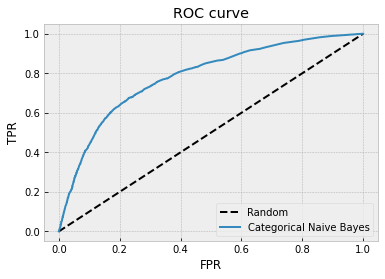


- optimal probability threshold:

0.36

- precision recall tradeoff:



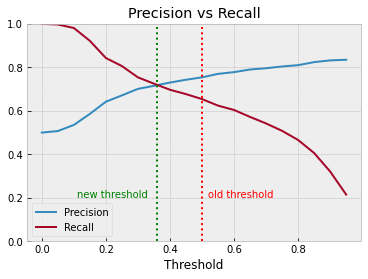


- performance metrics (new threshold):

accuracy = 0.719, auc_score = 0.719

precision = 0.721, recall = 0.714, f1-score = 0.717

- confusion matrix:



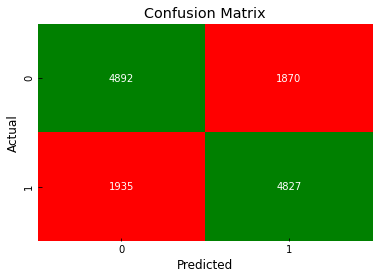

In [0]:
model_report(y_test, y_test_hat, y_test_proba, "Categorical Naive Bayes")

### Mixed NB

#### Training Model

In [0]:
num_nb_model, cat_nb_model, mixed_nb_model = mixed_NB(X_train_scaled, y_train)
y_test_hat, y_test_proba = mixed_NB_predict(num_nb_model, cat_nb_model, mixed_nb_model, X_test_scaled)

#### Model Report

Mixed Naive Bayes Model Report


- performance metrics (default threshold):

accuracy = 0.717, auc_score = 0.717

precision = 0.779, recall = 0.607, f1-score = 0.682

- ROC curve:



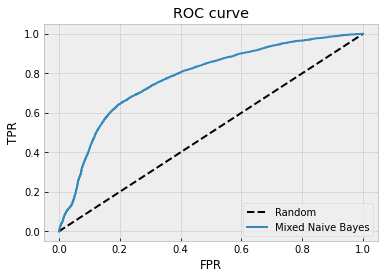


- optimal probability threshold:

0.35

- precision recall tradeoff:



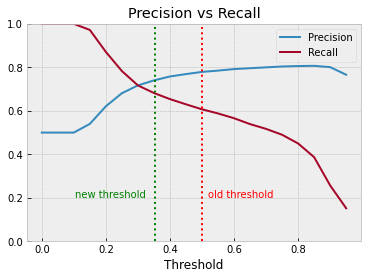


- performance metrics (new threshold):

accuracy = 0.722, auc_score = 0.722

precision = 0.741, recall = 0.682, f1-score = 0.71

- confusion matrix:



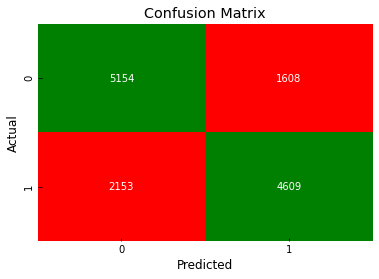

In [0]:
model_report(y_test, y_test_hat, y_test_proba, "Mixed Naive Bayes")

## Support Vector Machine

### Linear SVM

#### Training Model

In [0]:
linear_svm = LinearSVC()
linear_svm_model = linear_svm.fit(X_train_scaled, y_train)

y_test_hat = linear_svm_model.predict(X_test_scaled)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


#### Validating Model

In [0]:
classification_metrics(y_test, y_test_hat)

accuracy = 0.729, auc_score = 0.729

precision = 0.761, recall = 0.668, f1-score = 0.711


#### Plotting Confusion Matrix

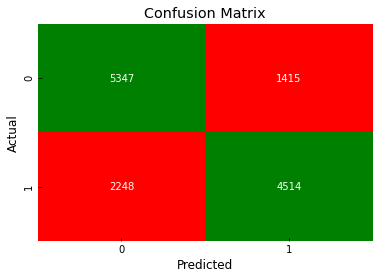

In [0]:
custom_confusion_matrix(y_test, y_test_hat)

#### Plotting Coefficients

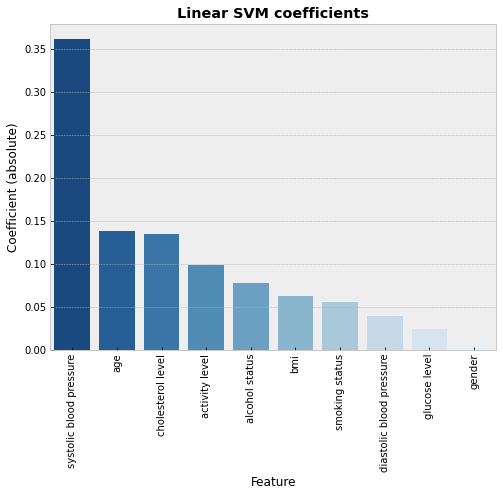

In [0]:
svm_coeffs = pd.DataFrame(list(zip(X_train_scaled.columns, np.absolute(linear_svm_model.coef_[0]))), columns = ['feature', 'coefficient magnitude'])
svm_coeffs_sorted = lr_coeffs.sort_values(by = 'coefficient magnitude', ascending = False)

plt.style.use('bmh')

fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)
sns.barplot(data = svm_coeffs_sorted, x = 'feature', y = 'coefficient magnitude', ax = ax, palette = 'Blues_r')
ax.set_title('Linear SVM coefficients', fontweight = 'bold')
ax.set_xlabel('Feature')
ax.set_ylabel('Coefficient (absolute)')
ax.set_xticklabels(['systolic blood pressure', 'age', 'cholesterol level', 'activity level', 'alcohol status', 'bmi', 'smoking status', 'diastolic blood pressure', 'glucose level', 'gender'])
plt.xticks(rotation = 90);

### Polynomial SVM

#### Training Model

In [0]:
poly_svm = SVC(kernel = 'poly')
%time poly_svm_model = poly_svm.fit(X_train_scaled, y_train)

y_test_hat = poly_svm_model.predict(X_test_scaled)

CPU times: user 1min 27s, sys: 126 ms, total: 1min 27s
Wall time: 1min 27s


#### Validating Model

In [0]:
classification_metrics(y_test, y_test_hat)

accuracy = 0.723, auc_score = 0.723

precision = 0.74, recall = 0.686, f1-score = 0.712


#### Plotting Confusion Matrix

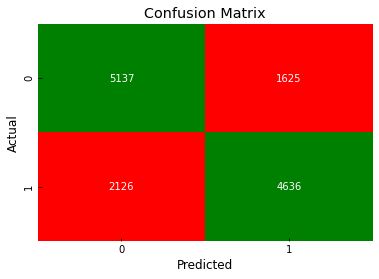

In [0]:
custom_confusion_matrix(y_test, y_test_hat)

### Radial SVM

#### Training Model

In [0]:
rbf_svm = SVC(kernel = 'rbf')
%time rbf_svm_model = rbf_svm.fit(X_train_scaled, y_train)

y_test_hat = rbf_svm_model.predict(X_test_scaled)

CPU times: user 2min 21s, sys: 140 ms, total: 2min 21s
Wall time: 2min 21s


#### Validating Model

In [0]:
classification_metrics(y_test, y_test_hat)

accuracy = 0.737, auc_score = 0.737

precision = 0.769, recall = 0.677, f1-score = 0.72


#### Plotting Confusion Matrix

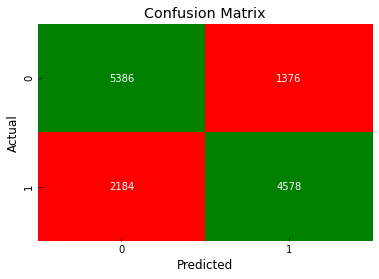

In [0]:
custom_confusion_matrix(y_test, y_test_hat)

### Sigmoid SVM

#### Training Model

In [0]:
sigmoid_svm = SVC(kernel = 'sigmoid')
%time sigmoid_svm_model = sigmoid_svm.fit(X_train_scaled, y_train)

y_test_hat = sigmoid_svm_model.predict(X_test_scaled)

CPU times: user 2min 11s, sys: 39 ms, total: 2min 11s
Wall time: 2min 11s


#### Validating Model

In [0]:
classification_metrics(y_test, y_test_hat)

accuracy = 0.65, auc_score = 0.65

precision = 0.651, recall = 0.647, f1-score = 0.649


#### Plotting Confusion Matrix

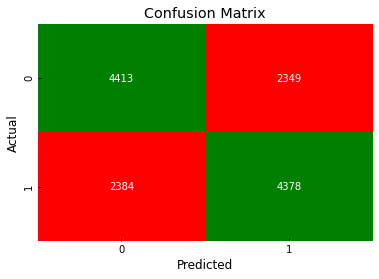

In [0]:
custom_confusion_matrix(y_test, y_test_hat)

## Decision Tree

### Baseline Model

#### Training Model

In [0]:
tree = DecisionTreeClassifier()
base_tree_model = tree.fit(X_train_binned, y_train)

y_test_hat = base_tree_model.predict(X_test_binned)

#### Valdiating Model

In [74]:
classification_metrics(y_test, y_test_hat)

accuracy = 0.707, auc_score = 0.707

precision = 0.733, recall = 0.651, f1-score = 0.69


### Hyperparameter Tuning

#### Inspecting range for max depth

In [0]:
depths = range(1,11)
scores = []
for depth in depths:
    tree = DecisionTreeClassifier(max_depth = depth)
    score = np.mean(cross_val_score(tree, X_train_binned, y_train, scoring = 'roc_auc', cv = 5))
    scores.append(score)

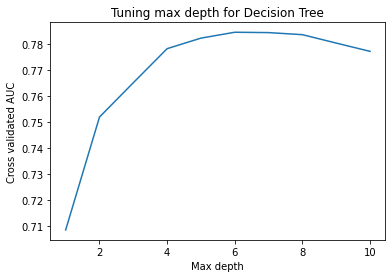

In [10]:
plt.plot(depths, scores)
plt.title('Tuning max depth for Decision Tree')
plt.xlabel('Max depth')
plt.ylabel('Cross validated AUC');

#### Inspecting range for minimum samples leaf

In [0]:
samples = range(25,525,25)
scores = []
for sample in samples:
    tree = DecisionTreeClassifier(min_samples_leaf = sample)
    score = np.mean(cross_val_score(tree, X_train_binned, y_train, scoring = 'roc_auc', cv = 5))
    scores.append(score)

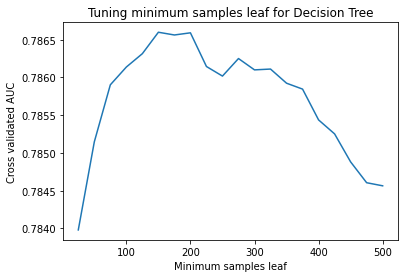

In [42]:
plt.plot(samples, scores)
plt.title('Tuning minimum samples leaf for Decision Tree')
plt.xlabel('Minimum samples leaf')
plt.ylabel('Cross validated AUC');

#### Tuning max depth, minimum samples leaf and impurity criterion

In [53]:
param_grid = {'max_depth': range(4,11), 'min_samples_leaf': np.arange(100,300,50), 'criterion': ['gini', 'entropy']}
tree_gs = GridSearchCV(tree, param_grid, scoring = 'roc_auc', cv = 5, n_jobs = -1)
%time tree_gs.fit(X_train_binned, y_train)
tree_gs.best_params_

CPU times: user 2.04 s, sys: 212 ms, total: 2.26 s
Wall time: 14.6 s


{'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 150}

### Tuned Model

#### Training Model

In [0]:
tuned_tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 7, min_samples_leaf = 150)
tuned_tree_model = tuned_tree.fit(X_train_binned, y_train)

y_test_hat = tuned_tree_model.predict(X_test_binned)

#### Validating Model

In [76]:
classification_metrics(y_test, y_test_hat)

accuracy = 0.729, auc_score = 0.729

precision = 0.732, recall = 0.722, f1-score = 0.727


#### Plotting Confusion Matrix

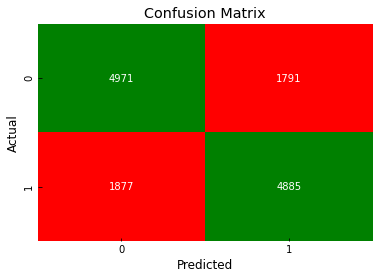

In [77]:
custom_confusion_matrix(y_test, y_test_hat)

#### Plotting Feature Importances

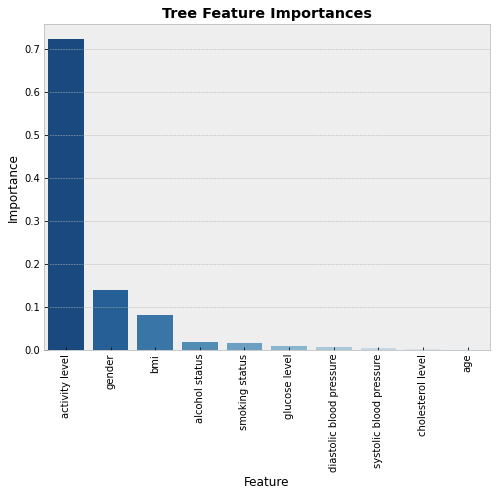

In [65]:
tree_feature_importances = pd.DataFrame(list(zip(X_train_scaled.columns, np.absolute(tuned_tree.feature_importances_))), columns = ['feature', 'importance'])
tree_feature_importances_sorted = tree_feature_importances.sort_values(by = 'importance', ascending = False)

plt.style.use('bmh')

fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)
sns.barplot(data = tree_feature_importances_sorted, x = 'feature', y = 'importance', ax = ax, palette = 'Blues_r')
ax.set_title('Tree Feature Importances', fontweight = 'bold')
ax.set_xlabel('Feature')
ax.set_ylabel('Importance')
ax.set_xticklabels(['activity level', 'gender', 'bmi', 'alcohol status', 'smoking status', 'glucose level', 'diastolic blood pressure', 'systolic blood pressure', 'cholesterol level', 'age'])
plt.xticks(rotation = 90);

#### Visualising Tree Structure

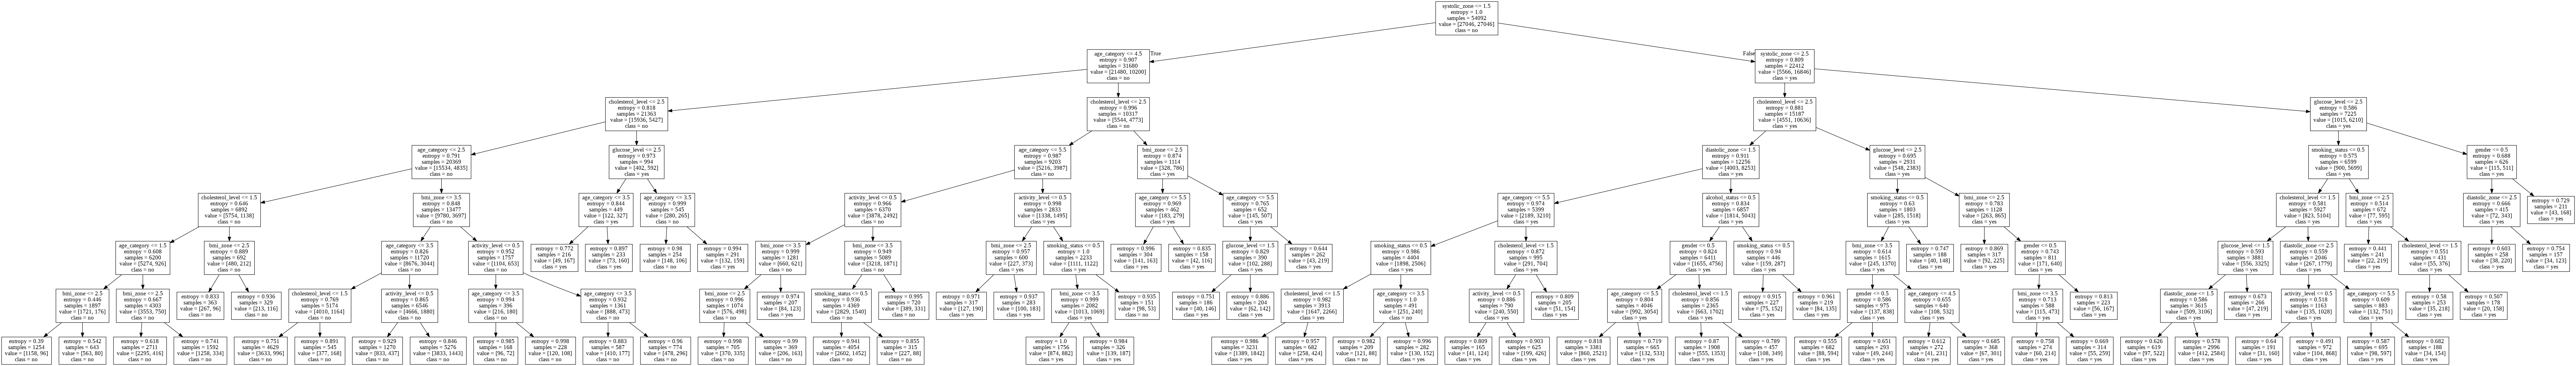

In [67]:
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
from IPython.display import Image

dot_data = export_graphviz(tuned_tree_model, out_file = None, feature_names = X_train_binned.columns, class_names = ['no','yes'])
graph = graph_from_dot_data(dot_data)
Image(graph.create_png())